In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
import glob
import os
import zarr

import random
import datetime
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import h5py
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from imgaug.augmentables.heatmaps import HeatmapsOnImage
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary
from utils.colormap import *
from unet_fov import *
from utils.mean_shift import MeanShift
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True


Training an Instance Segmentation model
==================================

So far we were only interested in classes, what is background and foreground, 
where are cells or person vs car. But in many cases we not only want to know
if a certain pixel belongs to a cell, but also to which cell.

For isolated objects, this is trivial, all connected foreground pixels form
one instance, yet often instances are very close together or even overlapping.
Then we need to think a bit more how to formulate the loss for our network
and how to extract the instances from the predictions.

Data
-------
For this task we use a subset of the data used in the kaggle data science bowl 2018 challenge
(https://www.kaggle.com/c/data-science-bowl-2018/)

Example image:
![image.png](utils/attachment/image.png)

All images show nuclei recorded using different microscopes and lighting conditions.
There are 30 images in the training set, 8 in the validation set and 16 in the test set.

#TODO: Create the KaggleDSB_dataset
-------
We will create the KaggleDSB_dataset, a subclass which inherits from torch.utils.data.Dataset.

When you just have limited number of data for training, data augmentation is essential to get good results.

TODO: Implement the part of **define_augmentation** for training data during training on the fly.Think about what kind of augmentation to use (e.g. flips, rotation, elastic).Use the imgaug library (https://imgaug.readthedocs.io/en/latest/), it provides a very extensive list of available augmentations.

In [2]:
# decompress data
from shutil import unpack_archive
unpack_archive(os.path.join('datasets','data_kaggle.tar.gz'), './')

In [43]:
class KaggleDSB_dataset(Dataset):
    """(subset of the) kaggle data science bowl 2018 dataset.
    The data is loaded from disk on the fly and in parallel using the torch dataset class.
    This enables the use of datasets that would not fit into main memory and dynamic augmentation.
    Args:
        root_dir (string): Directory with all the images.
        data_type (string): train/val/test, select subset of images
        prediction_type (string): default to be "metric_learning" for this notebook
        net_input_size (list): the input title size of you UNet
        padding_size (int): the number of pixels to pad on each side of the image before augmentation and cropping
        cache: if cache the data, default: False
    """
    def __init__(self,
                 root_dir,
                 data_type,
                 prediction_type="two_class",
                 net_input_size=None,
                 padding_size=None
                ):
        self.data_type = data_type
        self.files = glob.glob(os.path.join(root_dir, data_type, "*.zarr"))
        self.prediction_type = prediction_type
        self.net_input_size = net_input_size
        self.padding_size = padding_size
        self.define_augmentation()

    def __len__(self):
        return len(self.files)
    
    def define_augmentation(self):
        
        self.transform = iaa.Identity
        self.crop = None
        self.pad = None

        ###########################################################################
        # TODO (optional): Define your augmentation pipeline and uncomment the    #
        # following code                                                          #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # define self.transfrom by looking into the imgaug package reference
        
        self.transform = iaa.Sequential([
        iaa.Fliplr(0.5), # horizontally flip 50% of the images
        iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
        ], random_order=True)
        
        '''if self.net_input_size is not None:
            self.crop = ...     
        '''    
        if self.padding_size is not None:
            self.pad = iaa.Pad(px=4, pad_mode="edge")
            
            
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        
    
    def get_filename(self, idx):
        return self.files[idx]
        
    def __getitem__(self, idx):
        fn = self.get_filename(idx)
        raw, label = self.load_sample(fn)
        raw = self.normalize(raw)
        # augment for training
        if self.padding_size is not None:
            raw = self.pad(images = raw) # CHW -> CHW
            label = self.pad(images = label) # CHW -> CHW
        if self.data_type == "train":
            raw = np.transpose(raw, [1,2,0]) # CHW -> HWC
            label = np.transpose(label, [1,2,0]) # CHW -> HWC            
            raw, label = self.augment_sample(raw, label) # HWC -> HWC
            raw = np.transpose(raw, [2,0,1]) # HWC -> CHW
            label = np.transpose(label, [2,0,1]) # HWC -> CHW
        if self.net_input_size is not None:
            tmp = np.concatenate([raw, label], axis = 0).copy() # C1+C2 HW
            tmp = np.transpose(tmp, [1,2,0]) # CHW -> HWC 
            tmp = self.crop.augment_image(tmp) # HWC -> HWC
            tmp = np.transpose(tmp, [2,0,1])
            raw, label = np.expand_dims(tmp[0], axis=0), np.stack(tmp[1:],axis=0) # split
        raw, label = torch.tensor(raw), torch.tensor(label)
        return raw, label
    
    def augment_sample(self, raw, label):
        # stores float label (sdt) differently than integer label (rest)
        if self.prediction_type in ["sdt"]:
            label = HeatmapsOnImage(label, shape=raw.shape, min_value=-1.0, max_value=1.0)
            raw, label = self.transform(image=raw, heatmaps=label)
        else:
            label = label.astype(np.int32)
            label = SegmentationMapsOnImage(label, shape=raw.shape)
            raw, label = self.transform(image=raw, segmentation_maps=label)
            
        label = label.get_arr() 
        # some pytorch version have problems with negative indices introduced by e.g. flips
        # just copying fixes this
        label = label.copy()
        raw = raw.copy()
        return raw, label
    
    def normalize(self, raw):
        # z-normalization
        raw -= np.mean(raw)
        raw /= np.std(raw)
        return raw
    
    def load_sample(self, filename):
        data = zarr.open(filename)
        raw = np.array(data['volumes/raw'])
        if self.prediction_type == "two_class":
            label = np.array(data['volumes/gt_fgbg'])
        elif self.prediction_type == "affinities":
            label = np.array(data['volumes/gt_affs'])
        elif self.prediction_type == "sdt":
            label = np.array(data['volumes/gt_tanh'])
        elif self.prediction_type == "three_class":
            label = np.array(data['volumes/gt_threeclass'])
        elif self.prediction_type == "metric_learning":
            label = np.array(data['volumes/gt_labels'])
        label = label.astype(np.float32)
        return raw, label

Loss
-------
There are many different approaches to instance segmentation.
We will introduce three basic methods:

### Three-class model ###
This is an extension of the basic foreground/background (or two-class) model.
In addition a third class is introduced: the boundary.
Even if two instances are touching, there is a boundary between them. This way they can be separated. 
Instead of a single output (where an output of zero is one class and of one is the other class), the network outputs three values, one per class. And the loss function changes from binary to (sparse) categorical cross entropy.

![three_class.png](utils/attachment/three_class.png)

### Distance Transform ###
The label for each pixel is the distance to the closest boundary. 
The value within instances is negative and outside of instances is positive.
As the output is not a probability but an (in principle) unbounded scalar, the mean squared error loss function is used.

![sdt.png](utils/attachment/sdt.png)


### Edge Affinities ###
Here we consider not just the pixel but also its direct neighbors (in 2D the left neighbor and the upper neighbor are sufficient, right and down are redundant with the next pixel's left and upper neighbor).
Imagine there is an edge between two pixels if they are in the same class and no edge if not. If we then take all pixels that are directly and indirectly connected by edges, we get an instance. The network predicts the probability that there is an edge, this is called affinity.
As we are considering two neighbors per pixel, our network needs two outputs and as the output is a probability, we are using binary cross entropy

![affinities.png](utils/attachment/affinities.png)

### Metric Learning ###
In metric learning your model learns to predict an embedding vector for each pixel. These embedding vectors are learned such that vectors from pixels belonging to the same instance are similar to each other and dissimilar to the embedding vectors of other instances and the background. It can also be thought of as learning a false coloring where each instance is colored with a unique but arbitrary color.  
![metric_learning.png](utils/attachment/metric_learning.png)



#TODO: Predefine some conditions for CNN training
-------
We have 5 types of labels, corresponding to 5 **prediction_types** below.

For each case, we should define the corresponding output channel numbers, final activation layer, criterion(loss function) and dtye(the data type of the label).It would be clear to fill in these conditions after you look through the part of code about how we define training process.

TODO: Please fill in the missing code and uncomment one of the **prediction_type** to start your training.

In [87]:
from utils.disc_loss import DiscriminativeLoss

###########################################################################
# TODO: Uncomment the prediction_type (and corresponding conditions)      #
#       you would like to use for this exercice                           #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# Uncomment to choose one

#prediction_type = "two_class" # same as fg/bg
prediction_type = "affinities"
#prediction_type = "sdt"
#prediction_type = "three_class"
#prediction_type = "metric_learning"

if prediction_type == "two_class":
    out_channels = 1
    activation = torch.sigmoid
    loss_fn = torch.BCEWithLogitsLoss
    dtype = 'uint8'
elif prediction_type == "affinities":
    out_channels = 1
    activation = nn.Softmax
    loss_fn = nn.BCEWithLogitsLoss
    dtype = torch.uint8
elif prediction_type == "sdt":
    out_channels = 1
    activation = nn.ReLU
    loss_fn = nn.MSELoss
    dtype = 'float32'
elif prediction_type == "three_class":
    out_channels = 3
    activation = torch.Softmax
    loss_fn = torch.CrossEntropyLoss 
    dtype = 'unit8'
elif prediction_type == "metric_learning":
    out_channels = 10
    activation = torch.ReLU
    loss_fn = torch.CrossEntropyLoss
    dtype = 'uint8'
else:
    raise RuntimeError("invalid prediction type")
    
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

Create our input datasets, ground truth labels are chosen depending on the type:

In [81]:
# make datasets
root = 'data_kaggle_test'
padding_size = 12
batch_size = 4

data_train = KaggleDSB_dataset(root, "train", prediction_type=prediction_type, padding_size=padding_size)
data_val = KaggleDSB_dataset(root, "val", prediction_type=prediction_type, padding_size=padding_size)
data_test = KaggleDSB_dataset(root, "test", prediction_type=prediction_type, padding_size=padding_size)
# make dataloaders
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(data_val, batch_size=1, pin_memory=True)
test_loader = DataLoader(data_test, batch_size=1)

Let's have a look at some of the raw data and labels:


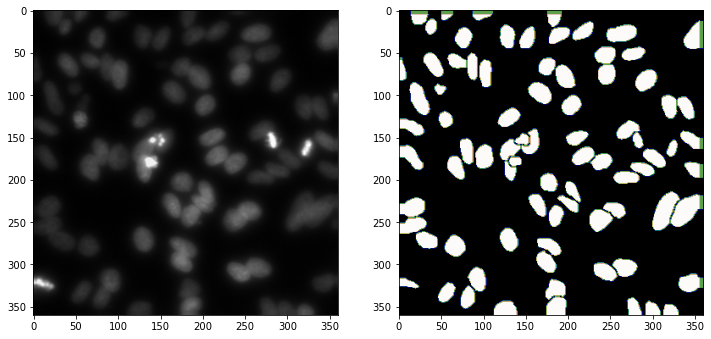

In [82]:
# repeatedly execute this cell to get different images
for image, label in data_train:
    break

label = np.squeeze(label, 0)
if prediction_type == "affinities":
    label = label[0] + label[1]

fig=plt.figure(figsize=(12, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(label), cmap='gist_earth')
plt.show()

### Receptive Field of View

Field of view at depth 1:   5 (color: yellow)
Field of view at depth 2:  18 (color: red)
Field of view at depth 3:  44 (color: green)
Field of view at depth 4:  96 (color: blue)


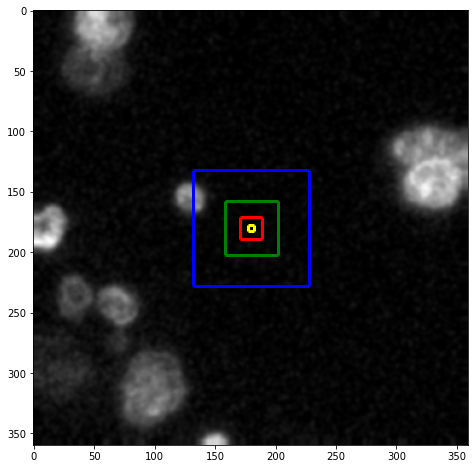

In [83]:
images, labels = data_train[random.randrange(len(data_train))]
rnd = random.randrange(len(images))
image = images[rnd]
label = labels[rnd]


net_t = image
fovs = []
d_factors = [[2,2],[2,2],[2,2]]

net = UNet(in_channels=1,
           num_fmaps=6,
           fmap_inc_factors=2,
           downsample_factors=d_factors,
           padding='same',
           num_fmaps_out=out_channels
          )

for level in range(len(d_factors)+1):
    fov_tmp, _ = net.rec_fov(level , (1, 1), 1)
    fovs.append(fov_tmp[0])

fig=plt.figure(figsize=(8, 8))
colors = ["yellow", "red", "green", "blue", "magenta"]
plt.imshow(image, cmap='gray')
for idx, fov_t in enumerate(fovs):
    print("Field of view at depth {}: {:3d} (color: {})".format(idx+1, fov_t, colors[idx]))
    xmin = image.shape[1]/2 - fov_t/2
    xmax = image.shape[1]/2 + fov_t/2
    ymin = image.shape[1]/2 - fov_t/2
    ymax = image.shape[1]/2 + fov_t/2
    plt.hlines(ymin, xmin, xmax, color=colors[idx], lw=3)
    plt.hlines(ymax, xmin, xmax, color=colors[idx], lw=3)
    plt.vlines(xmin, ymin, ymax, color=colors[idx], lw=3)
    plt.vlines(xmax, ymin, ymax, color=colors[idx], lw=3)
plt.show()

#TODO: Define our U-Net
==============
As before, we define our neural network architecture and can choose the depth and number of feature maps at the first convolution.

This neural network is composed by stacking one UNet instance and one convolution layer. The UNet Class is defined in the **unet_fov.py** file and we use the default setting that the number of feature maps of the UNet instance output will be eqaul to the number of feature maps at the first convolution. Then we use one more convolution layer with kernel_size=1 to generate the final output with number of feature maps equal to what we want.

For the meaning of parameters of the UNet class, please refer to the **unet_fov.py** file.

#TODO: Please fill in the missing part of code about how to define the **net**.

In [84]:
torch.manual_seed(42)

###########################################################################
# TODO: Define the net and uncomment the following code                   #
# Please define a UNet which use same padding                             #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
'''
The explanation of the arguments for the UNet instances are shown below. 
For more detailed instruction, please look at unet_fov.py.
Args:

    in_channels:

        The number of input channels.

    num_fmaps:

        The number of feature maps in the first layer. This is also the
        number of output feature maps. Stored in the ``channels``
        dimension.

    fmap_inc_factors:

        By how much to multiply the number of feature maps between
        layers. If layer 0 has ``k`` feature maps, layer ``l`` will
        have ``k*fmap_inc_factor**l``.

    downsample_factors:

        List of tuples ``(y, x)`` to use to down- and up-sample the
        feature maps between layers.


    activation:

        Which activation to use after a convolution. Accepts the name
        of any tensorflow activation function (e.g., ``ReLU`` for
        ``torch.nn.ReLU``).

    constant_upsample (optional):

        If set to true, perform a constant upsampling instead of a
        transposed convolution in the upsampling layers.
'''

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

d_factors = [[2,2],[2,2],[2,2],[2,2]]

net = torch.nn.Sequential(
     UNet(in_channels=1,
     num_fmaps=32,
     fmap_inc_factors=2,
     downsample_factors=d_factors,
     activation='ReLU',
     padding='same',
     num_fmaps_out=32,
     constant_upsample=False
     ),
     torch.nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=1, padding=0, bias=True))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
summary(net, (1, 384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 384, 384]             320
              ReLU-2         [-1, 32, 384, 384]               0
            Conv2d-3         [-1, 32, 384, 384]           9,248
              ReLU-4         [-1, 32, 384, 384]               0
          ConvPass-5         [-1, 32, 384, 384]               0
         MaxPool2d-6         [-1, 32, 192, 192]               0
        Downsample-7         [-1, 32, 192, 192]               0
            Conv2d-8         [-1, 64, 192, 192]          18,496
              ReLU-9         [-1, 64, 192, 192]               0
           Conv2d-10         [-1, 64, 192, 192]          36,928
             ReLU-11         [-1, 64, 192, 192]               0
         ConvPass-12         [-1, 64, 192, 192]               0
        MaxPool2d-13           [-1, 64, 96, 96]               0
       Downsample-14           [-1, 64,

#TODO: Training
=======

Before we start training, we have to compile the network and set the optimizer (try playing with the learning rate, a higher learning rate can lead to faster training, but also to divergence or lower performance).

To visualize our results we now use Tensorboard. This is a very useful extension for your browser that let's you look into networks computational graph and the weights and metrics over time.

In [85]:
def training_step(model, loss_fn, optimizer, feature, label, prediction_type):
    # speedup version of setting gradients to zero
    for param in model.parameters():
        param.grad = None
    # forward
    logits = model(feature) # B x C x H x W
    shape_dif = np.array(label.shape[-2:]) - np.array(logits.shape[-2:])
    if np.sum(shape_dif)>0:
        label = label[:,:,shape_dif[0]//2:-shape_dif[0]//2,shape_dif[0]//2:-shape_dif[0]//2]        
    if prediction_type == "three_class":
        label=torch.squeeze(label,1) #label.shape=[N,H,W]
    loss_value = loss_fn(input=logits, target=label)  #logits.shape=[N,C,H,W] label.shape=[N,H,W]
    # backward if training mode
    if net.training:
        loss_value.backward()
        optimizer.step()
    if activation is not None:
        output = activation(logits)
    else:
        output = logits
    outputs = {
        'pred': output,
        'logits': logits,
    }
    return loss_value, outputs

In [88]:
training_steps = 2000
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
###########################################################################
# TODO: put the model and the loss function to device and define the      #
# optimizer with its learning rate                                        #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

net = net.to(device)
loss_fn = loss_fn.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.00005)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

AttributeError: 'torch.device' object has no attribute '_apply'

In [89]:
# set flags
net.train() 
loss_fn.train()
step = 0

# this might take ~10 ish minutes
with tqdm(total=training_steps) as pbar:
    while step < training_steps:
        # reset data loader to get random augmentations
        np.random.seed()
        tmp_loader = iter(train_loader)
        for feature, label in tmp_loader:
            label = label.type(dtype)
            label = label.to(device)
            feature = feature.to(device)
            loss_value, pred = training_step(net, loss_fn, optimizer, feature, label, prediction_type)
            writer.add_scalar('loss',loss_value.cpu().detach().numpy(),step)
            step += 1
            pbar.update(1)
            if step % 100 == 0:
                net.eval()
                tmp_val_loader = iter(val_loader)
                acc_loss = []
                for feature, label in tmp_val_loader:                    
                    label = label.type(dtype)
                    label = label.to(device)
                    feature = feature.to(device)
                    loss_value, _ = training_step(net, loss_fn, optimizer, feature, label, prediction_type)
                    acc_loss.append(loss_value.cpu().detach().numpy())
                writer.add_scalar('val_loss',np.mean(acc_loss),step)
                net.train()

TypeError: train() missing 1 required positional argument: 'self'

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs

#or run:
#!tensorboard --logdir=runs 
#to view in separate window

Postprocessing
=============

In contrast to the semantic segmentation we postprocessing to extract the final segmentation is a bit more involved and consists of x steps for the two class, three class, sdt and affinity models:
- based on the prediction we define a surface
- we extract the maxima from this surface
- we use the maxima as seeds in an off-the-shelf watershed algorithm
- and mask the result with the foreground
The foreground areas covered by the watershed from each seed point correspond to the instances.
The resulting instances are then matched to the ground truth instances (at least 50% overlap) to get our final score (averaged over all instances and all test images)

For the metric learning model, the post-processing is a bit different. The embeddings are clustered with the mean shift algorithm and the clusters are numbered. You can think of this as clustering pixels by their color, such that the pixels that belong to one uniquely colored instance end up in one cluster and get the same number assigned. 

In [ ]:
%reload_ext autoreload
%autoreload 2
from utils.label import *
from utils.evaluate import *

# set flag
net.eval()
# set hyperparameters
# thresholds have to be tuned after training on the validation set
if prediction_type == "two_class":
    fg_thresh = 0.7
    seed_thresh = 0.8
elif prediction_type == "three_class":
    #pred = np.transpose(pred, [2, 0, 1])
    fg_thresh = 0.5
    seed_thresh = 0.6
elif prediction_type == "sdt":
    fg_thresh = 0.0
    seed_thresh = -0.12
elif prediction_type == "affinities":
    fg_thresh = 0.9
    seed_thresh = 0.99
elif prediction_type == "metric_learning":
    fg_thresh = 0.5
    seed_thresh = None
    
def unpad(pred, padding_size):
    return pred[padding_size:-padding_size,padding_size:-padding_size]

avg = 0.0
for idx, (image, gt_labels) in enumerate(test_loader):
    image = image.to(device)
    pred = net(image)
    image = np.squeeze(image.cpu())
    gt_labels = np.squeeze(gt_labels)
    pred = np.squeeze(pred.cpu().detach().numpy(),0)
    #if prediction_type in ["three_class", "affinities","two_class","sdt"]:
    pred = unpad(np.transpose(pred,(1,2,0)), padding_size)
    pred = np.transpose(pred,(2,0,1))
    if prediction_type == "affinities":
        gt_labels = gt_labels[0] + gt_labels[1]
    labelling, surface = label(pred, prediction_type, fg_thresh=fg_thresh, seed_thresh=seed_thresh)
    ap, precision, recall, tp, fp, fn = evaluate(labelling, data_test.get_filename(idx))
    avg += ap
    print(np.min(surface), np.max(surface))
    labelling = labelling.astype(np.uint8)
    print("average precision: {}, precision: {}, recall: {}".format(ap, precision, recall))
    print("true positives: {}, false positives: {}, false negatives: {}".format(tp, fp, fn))
    if prediction_type == "metric_learning":
        surface = surface+np.abs(np.min(surface, axis=(1,2)))[:,np.newaxis,np.newaxis]
        surface /= np.max(surface, axis=(1,2))[:,np.newaxis,np.newaxis]
        surface = np.transpose(surface, (1,2,0))

    fig=plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 4, 1)
    ax.set_title("raw")
   
    image=unpad(image,(image.shape[-1]-labelling.shape[-1])//2)
    plt.imshow(np.squeeze(image))
    ax = fig.add_subplot(1, 4, 2)
    ax.set_title("gt labels")
    gt_labels=unpad(gt_labels,(gt_labels.shape[-1]-labelling.shape[-1])//2)
    plt.imshow(np.squeeze(1.0-gt_labels))
    
    ax = fig.add_subplot(1, 4, 3)
    ax.set_title("prediction")
    plt.imshow(np.squeeze(1.0-surface))
    ax = fig.add_subplot(1, 4, 4)
    ax.set_title("pred segmentation")
    plt.imshow(np.squeeze(labelling), cmap=rand_cmap, interpolation="none")

    plt.show()
avg /= (idx+1)
print("average precision on test set: {}".format(avg))

In [ ]:
# try different methods, hyperparameters, and see how you can improve the results